In [1]:
import cartopy.crs as ccrs
import cmocean
import easygems.healpix as egh
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.spatial import Delaunay


def open_dataset(expid="eurohpc_amip_r02b08", group="atm_2d_ml", regex_time="*Z"):
    """Return a (somewhat) nicely shaped ICON dataset."""
    return xr.open_mfdataset(
        f"/scratch/project_465000548/kluftluka/icon/experiments/{expid}/{expid}_{group}_{regex_time}.nc"
    ).squeeze(
    ).rename_dims(
        {"ncells": "cell"}
    ).drop_vars(
        ["height", 
         "height_2",
        ],
    )


def open_grid(expid="eurohpc_amip_r02b08"):
    """Open the ICON horiztonal grid for a given experiment."""
    return xr.open_mfdataset(f"/scratch/project_465000548/kluftluka/icon/experiments/{expid}/icon_grid_*_G.nc")
    

def get_latlon_grid(hpz=7, nest=True):
    """Return two-dimensional longitude and latitude grids."""
    lons, lats = hp.pix2ang(2**hpz, np.arange(hp.nside2npix(2**hpz)), nest=nest, lonlat=True)

    return (lons + 180) % 360 - 180, lats


def get_weights(points, xi):
    """Compute interpolation weights."""
    tri = Delaunay(np.stack(points, axis=-1))  # Compute the triangulation
    targets = np.stack(xi, axis=-1)
    triangles = tri.find_simplex(targets)

    X = tri.transform[triangles, :2]
    Y = targets - tri.transform[triangles, 2]
    b = np.einsum("...jk,...k->...j", X, Y)
    weights = np.concatenate([b, 1 - b.sum(axis=-1)[..., np.newaxis]], axis=-1)
    src_idx = tri.simplices[triangles]
    valid = triangles >= 0

    return {"src_idx": src_idx, "weights": weights, "valid": valid}


def remap(var, src_idx, weights, valid):
    """Apply given interpolation weights."""
    return np.where(valid, (var[src_idx] * weights).sum(axis=-1), np.nan)

In [2]:
# Compute interpolation weights (this may take some time...)
grid = open_grid()
grid_lon, grid_lat = get_latlon_grid(hpz=8)
weight_kwargs = get_weights(points=(np.degrees(grid.clon), np.degrees(grid.clat)), xi=(grid_lon, grid_lat))

In [3]:
# Lazily (!) apply interpolation weights to the output dataset
ds = xr.apply_ufunc(
    remap,
    open_dataset(),
    kwargs=weight_kwargs,
    input_core_dims=[["cell"]],
    output_core_dims=[["pix"]],
    dask="parallelized",
    vectorize=True,
    output_dtypes=["f4"],
    dask_gufunc_kwargs={
        "output_sizes": {"pix": grid_lon.size},
    },
).assign_coords({"lon": grid_lon, "lat": grid_lat})

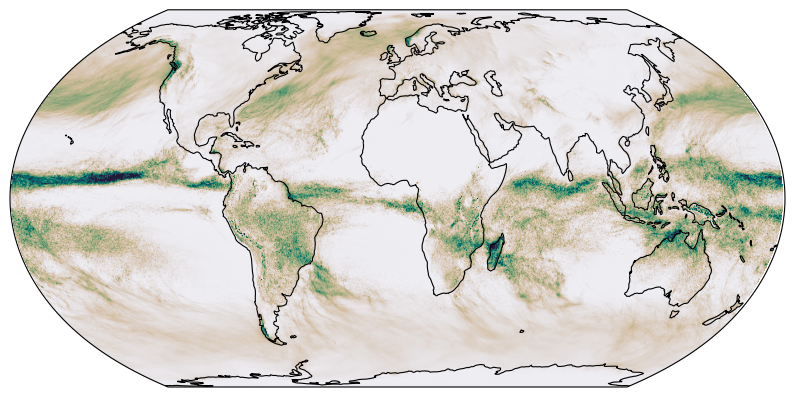

In [7]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.EqualEarth()})
ax.set_global()
ax.coastlines(lw=0.8)
egh.healpix_show(
    ds["pr"].sel(time="1979-01").mean("time"),
    cmap="cmo.rain",
    vmin=0,
    vmax=4e-4,
    method="linear",
)